# Image Deblurring - June Exam

### Dataset creation - DO NOT MODIFY

In [1]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np

def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

# Davide Buldrini 
MATRICOLA: 1026874
## Deep learning Exam
*June 2022* <BR>
**Task**

The task consists in creating a deblurring deep learning model, aimed to remove gaussian blur and gaussian noise from images. 

You will need to create a model which, taken a blurred image X, is able to reconstruct the original deblurred image y. 

**Dataset** 

The dataset is built starting from CIFAR-10 images collection, we created a notebook(save the file linked as .ipynb) to perform the creation of the dataset without you downloading it. Do not modify the function, but feel free to further split the data to build a validation set, if needed. 

The split into different data split is left to you, perform it as you like, making sure it is meaningful. 

**Structure**

Write a notebook explaining every step you take in the building of the pipeline and DON'T clear the output of the cells when you submit it.  

Make sure to test the model in order to prove robustness and lack of overfitting.

The metric you will need to use to evaluate the results is the MSE.

**Hints and requirements**

There are different strategies to remove such noise from images, feel free to use the one you consider to be the most appropriate, keeping in mind that the blurring is Gaussian and so is the noise. 

The metrics will be evaluated on the reconstructed images, so provide a way to check the results on a batch composed of original images and reconstructed images.

You can't use ANY pre-trained models for this exam and try to build models with less than 10 milions trainable parameters. 

Try to remember all the instructions we provided in the last lab lesson about the submission, make sure to output the metrics of your final model and use the adequate strategy for the task. 

Save the weights of your model and keep them until the discussion, we might ask you to provide them. 

## Creating train and test set
The train and test are given by the function *getDataset()*, then a brief analysis of the imagine will be usefull to choose better the strategy to follow.  


In [2]:
(x_train, y_train), (x_test, y_test) = getDataset()

**Analysing the data**

In [3]:
print ('The dimension of an image is: {};'.format(x_train[1].shape))
print ('The size of training set is: {};'.format(x_train.shape[0]))
print ('The size of the test set is: {}.'.format(x_test.shape[0]))

The dimension of an image is: (32, 32, 3);
The size of training set is: 50000;
The size of the test set is: 10000.


**Printing a some of the images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


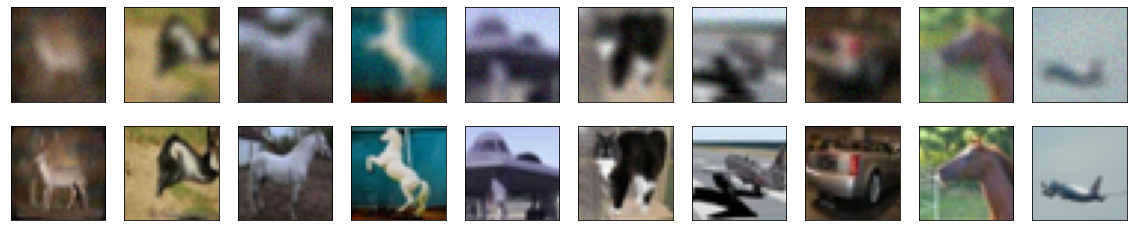

In [4]:
import matplotlib.pyplot as plt
def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(32, 32,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(32, 32, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

# Display the train data and a version of it with added noise
display(x_train, y_train )

Our aim is to create a deep learning model which, taken a blurred image **x**, is able to reconstruct the original deblurred image **y** removing gaussian blur and gaussian noise from images. <br>
The metric used to evaluate the results is the **MSE**. The images are blurred and have some Gaussian noise, but they have not al lot of pixel (and their value has been normalized) so we can expect that the MSE will not be so big also without doing anything. So we will calculate this MSE and then we want the model to achieve a better result.

In [5]:
from sklearn.metrics import mean_squared_error
def mse(y_true, y_pred):
  mse=0
  for i in range(len(y_true)):
    mse += mean_squared_error(y_true[i].flatten(), y_pred[i].flatten())
  return mse/len(y_true)
initial_mse = mse(y_test, x_test)
print('The MSE without doing any Deblurring is : {}'.format(initial_mse))

The MSE without doing any Deblurring is : 0.006727312534560363


## Models
In this section after importing the libraries, two models are presented.
For each model we will follow this pipeline:

*   Model creation
*   the model is fitted
*   Look for Overfitting and eventualy try to fix it

In [6]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras.utils import plot_model

In [7]:
# Structure of our immges
img_shape=x_train[1].shape

### Fully convolutional model
The first model presented is a fully convolutional model. Composed of eight convolutional layers, the first layer is a convolution with *kernel_size=5. The number of channels increases for the following three layers and then is progressively decresead to reach three (i.e th number of channels of the output image). <br>

The size of the Guassian Blurring filter is 5 so it is worth to try to apply a first convlution with *kernel_size=5*, (using only convolution with *kernel_size=5* will increase a lot the number o paramteres an also the ammount of overfitting) 

In [8]:
# number of channelS
n_ch=32

def build_cnn(input_shape, n_ch, L=3):
    x = ks.layers.Input(shape=input_shape)
    h = x
    for i in range(L):
        if i == 0:
          h = ks.layers.Conv2D(n_ch, kernel_size=5, padding='same')(h)
        h = ks.layers.Conv2D(n_ch, kernel_size=3, padding='same')(h)
        h = ks.layers.ReLU()(h)
        

        n_ch = 2*n_ch
   
    n_ch = n_ch/2                                 
    for i in range(L):
        n_ch = n_ch/2
        h = ks.layers.Conv2D(n_ch, kernel_size=3, padding='same')(h)
        h = ks.layers.ReLU()(h)

        

    y = ks.layers.Conv2D(3, kernel_size=1, activation='sigmoid')(h)
    return ks.models.Model(x, y)

_CNN_model = build_cnn(img_shape, n_ch, L=3)        

print(_CNN_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 re_lu (ReLU)                (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 re_lu_1 (ReLU)              (None, 32, 32, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       73856 

The Training of this model with loss = "mean_squared_error" reaches a plateau in a few epochs and, even using the callbacks, the model is not yet able to decrease the val_loss. <br>
To avoid this problem a different loss (loss =  ["mean_absolute_error"](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanAbsoluteError)) has been used for the first epochs of the trainnig in order to have a different gradient. And then use MSE as a loss and a bigger batch_size only in the last few epochs . <br>
The choiche of mean_absolute_error is because it has a similar structure <br>  

MSE = $ \frac{1}{n}\sum (y_i - \tilde{y_i})^2$  <br>
MAE = $ \frac{1}{n}\sum \mid y_i - \tilde{y_i} \mid $

This trick has slightly reduced the MSE for the test, even if it didn't give much better results.

On the other hand the first convolution with *kernel_size=5* seems very usefull, the convolutional model reaches an MSE on test of 0.00258 (n_ch = 32 and aoround 200.000 parameters), while the same model using only convolutions with  *kernel_size=3* reaches 0.002571 but with n_ch = 64 and more than 700.000 parameters.

Two callbacks have been added in order to manage the learning rate and to stop the training when the model in improving on test data.

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau #ModelCheckpoint

In [10]:
BATCH_SIZE = 32 
N_EPOCHS = 30

reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.2,
                              patience=4, min_lr=0.0001)
early_st=EarlyStopping(monitor='val_mean_squared_error',min_delta=0.00001, patience=4)

_CNN_model.compile(optimizer=ks.optimizers.Adam(learning_rate=1e-3), 
                  loss="mean_absolute_error", metrics=['mean_squared_error'])

histmsa = _CNN_model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=N_EPOCHS,
              validation_split=0.1,
              #validation_data = (x_test, y_test),
              callbacks=[reduce_lr,early_st])

Epoch 1/30
1407/1407 [==============================] - 28s 14ms/step - loss: 0.0514 - mean_squared_error: 0.0057 - val_loss: 0.0423 - val_mean_squared_error: 0.0036 - lr: 0.0010
Epoch 2/30
1407/1407 [==============================] - 19s 13ms/step - loss: 0.0414 - mean_squared_error: 0.0035 - val_loss: 0.0426 - val_mean_squared_error: 0.0035 - lr: 0.0010
Epoch 3/30
1407/1407 [==============================] - 19s 14ms/step - loss: 0.0398 - mean_squared_error: 0.0033 - val_loss: 0.0386 - val_mean_squared_error: 0.0031 - lr: 0.0010
Epoch 4/30
1407/1407 [==============================] - 19s 14ms/step - loss: 0.0391 - mean_squared_error: 0.0031 - val_loss: 0.0404 - val_mean_squared_error: 0.0032 - lr: 0.0010
Epoch 5/30
1407/1407 [==============================] - 19s 13ms/step - loss: 0.0384 - mean_squared_error: 0.0030 - val_loss: 0.0373 - val_mean_squared_error: 0.0029 - lr: 0.0010
Epoch 6/30
1407/1407 [==============================] - 19s 13ms/step - loss: 0.0380 - mean_squared_error

In [11]:
BATCH_SIZE = 400 #bigger batch size
N_EPOCHS = 30

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.0001)
early_st=EarlyStopping(monitor='val_loss',min_delta=0.00001, patience=4)

_CNN_model.compile(optimizer=ks.optimizers.Adam(learning_rate=1e-3),  #learning_rate=1e-4 in 6 epochs arriva 0.0030 su val a prova con default 0.001
                  loss="mean_squared_error")

histmse = _CNN_model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=N_EPOCHS,
              validation_split=0.1,
              #validation_data = (x_test, y_test),
              callbacks=[reduce_lr,early_st])

Epoch 1/30
113/113 [==============================] - 20s 148ms/step - loss: 0.0030 - val_loss: 0.0027 - lr: 0.0010
Epoch 2/30
113/113 [==============================] - 15s 132ms/step - loss: 0.0026 - val_loss: 0.0026 - lr: 0.0010
Epoch 3/30
113/113 [==============================] - 15s 132ms/step - loss: 0.0026 - val_loss: 0.0026 - lr: 0.0010
Epoch 4/30
113/113 [==============================] - 15s 132ms/step - loss: 0.0026 - val_loss: 0.0026 - lr: 0.0010
Epoch 5/30
113/113 [==============================] - 15s 132ms/step - loss: 0.0026 - val_loss: 0.0026 - lr: 0.0010
Epoch 6/30
113/113 [==============================] - 15s 132ms/step - loss: 0.0026 - val_loss: 0.0026 - lr: 0.0010
Epoch 7/30
113/113 [==============================] - 15s 132ms/step - loss: 0.0026 - val_loss: 0.0026 - lr: 0.0010
Epoch 8/30
113/113 [==============================] - 15s 132ms/step - loss: 0.0026 - val_loss: 0.0026 - lr: 2.0000e-04
Epoch 9/30
113/113 [==============================] - 15s 133ms/step

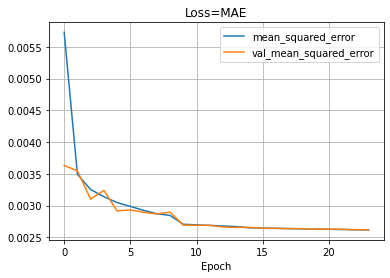

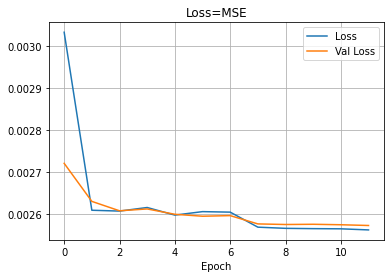

In [12]:
# Check if the model overfits
loss_history = histmsa.history['mean_squared_error']
val_loss_history = histmsa.history['val_mean_squared_error']

plt.plot(loss_history)
plt.plot(val_loss_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['mean_squared_error', 'val_mean_squared_error'])
plt.title('Loss=MAE')
plt.show()

loss_history = histmse.history['loss']
val_loss_history = histmse.history['val_loss']

plt.plot(loss_history)
plt.plot(val_loss_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'])
plt.title('Loss=MSE')
plt.show()

In different trainings the loss on the validation set is not so stable  in the first epochs of the second part of the trainig, but then it stabilizes soon. The bigger batch size helps to compute a more stable gradient. accoding to this paper decreasing the learning rate can be simulated by increasing the [batch size](https://arxiv.org/abs/1711.00489).

In [13]:
y_test_pred1 = _CNN_model.predict(x_test)

print('The MSE for the test set is: {}'.format(mse(y_test, y_test_pred1)))
print('while the difference between the original and the blurred data without doing anithing is: {}'.format(initial_mse)) 

The MSE for the test set is: 0.00258461835022153
while the difference between the original and the blurred data without doing anithing is: 0.006727312534560363


The results of this simple convolutional model are not so bad, but maybe it is possible to reach better result using a more structured model. The structure is really simple and the number of parametres is low, so it is not able to improve anymore (during other training reaches some sligtly better result this model seems no able to reache an MSE smaller than 0.0025 ).

### Unet
The second idea for the model is to use an **Autoencoder**, the first test with three layers for encoding, three layers for decoding, and an additional convolutional layer before the output, didn't performed deblurrig significatively better than the the previous model. <br>

During the fourth lab of the course, the **Unet** has been used for segmentation, now it has been slightly modified for denoising. <br>
Gaussian blurring is local so maybe the skip connections of the Unet can help the model to reach better results,furthermore, since the purpose of the network is to reconstruct the image, these connections can transmit important local information. 
<br>

**Reasons to change / modify some parts of the model** <br>

The images have the shape = (32, 32, 3) and even with a small number of floor, after the downsampling the output of the last encoding layer has the first two dimensions really small, so some infomations may be lost. To avoid that, before the downsampling, an UpSampling2D layer has been added (also a transposed convolution has been used for the same purpose in previous tests). To have the output of the same dimension as the input image a convloutional layer with stride 2 has been added at the end of the decoding (adding a MaxPooling after the decoding can let the model lose some informations).


### The modified Unet
This model clearly inspired by Unet, but it has some differences:

*   A customized downsampling in wich MaxPooling and convolution with strides 2 are alternated.
*   At the beginning of the model has been Added an Upsampling layers
*   A Convolutional layer with stride 2 has been added at the end of the decoding.
*   The last convolution has 3 channel because the input image while for segmentation one channel was enough.


In [23]:
def build_unet(input_shape, n_ch=32, L=4, conv_per_L=2):
    # number of channels, which is set to 32.
    # L = number of floors
    # conv_per_L = number of convolutions every level.
    x = ks.layers.Input(shape=input_shape)
    h = ks.layers.UpSampling2D(size=(2,2))(x)
    # DOWN
    backup_layers = []
    #h = x
    
    for l in range(L):

        # Each floor in the descent phase
        for c in range(conv_per_L):
          
            h = ks.layers.Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ks.layers.ReLU()(h)
            

        if l < L-1: # We don't want to downsample at the last level
            # Downsample
          if l % 2 == 0:
            backup_layers.append(h) # save for the skip connection 
            h = ks.layers.Conv2D(n_ch, 3, strides=(2,2), padding='same', activation='relu')(h)
          else:
            backup_layers.append(h)
            h = ks.layers.MaxPool2D(padding='same')(h)
           # Update the channels
          n_ch = n_ch * 2
    
    # UP (pay attention to do not double count the last level)
    for l in range(L-1):
        # Reduce the channels
        n_ch = n_ch // 2

        # Upsample
        h = ks.layers.Conv2DTranspose(n_ch, 3, 2, padding='same')(h)

        # Concatenate
        h = ks.layers.concatenate([h, backup_layers.pop(-1)])

        # Each floor in the up phase
        for c in range(conv_per_L):
            h = ks.layers.Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ks.layers.ReLU()(h)
    h = ks.layers.Conv2D(n_ch, 3, strides=(2,2), padding='same')(h)
    # Output
    y = ks.layers.Conv2D(3, 1, activation='sigmoid')(h)
    return ks.models.Model(x, y)
        
unet_model = build_unet((32, 32, 3))

In [24]:
unet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 up_sampling2d_1 (UpSampling2D)  (None, 64, 64, 3)   0           ['input_3[0][0]']                
                                                                                                  
 conv2d_26 (Conv2D)             (None, 64, 64, 32)   896         ['up_sampling2d_1[0][0]']        
                                                                                                  
 re_lu_20 (ReLU)                (None, 64, 64, 32)   0           ['conv2d_26[0][0]']              
                                                                                            

In [16]:
print(plot_model(unet_model)) # I saved this 

<IPython.core.display.Image object>


In [25]:
BATCH_SIZE = 38 # 32 is defaul I have tried also 64 to see if a bigger batch size would lead to a better and more stable results  
N_EPOCHS = 100

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.00003)  
early_st=EarlyStopping(monitor='val_loss',min_delta=0.000001, patience=2) # increase the patience if the trainig stops too early 

#file_path1=r'C:\Users\david\OneDrive\vecchio onedrive'
#mchk=tf.keras.callbacks.ModelCheckpoint( filepath=file_path1,  monitor="val_loss", verbose=1,save_best_only=True, save_weights_only=True, mode="auto", save_freq="epoch" )

unet_model.compile(optimizer=ks.optimizers.Adam(learning_rate=1e-3), # learning_rate=1e-4 can bee good 17 epoche 0.0025 (0.0023 with 1e-3)
                  loss='mean_squared_error')

# Training
histu = unet_model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=N_EPOCHS,
              validation_split=0.1,
              #validation_data = (x_test, y_test),
              callbacks=[reduce_lr,early_st])

Epoch 1/100
1185/1185 [==============================] - 66s 54ms/step - loss: 0.0047 - val_loss: 0.0029 - lr: 0.0010
Epoch 2/100
1185/1185 [==============================] - 63s 54ms/step - loss: 0.0027 - val_loss: 0.0029 - lr: 0.0010
Epoch 3/100
1185/1185 [==============================] - 63s 54ms/step - loss: 0.0025 - val_loss: 0.0026 - lr: 0.0010
Epoch 4/100
1185/1185 [==============================] - 64s 54ms/step - loss: 0.0024 - val_loss: 0.0023 - lr: 0.0010
Epoch 5/100
1185/1185 [==============================] - 65s 55ms/step - loss: 0.0023 - val_loss: 0.0023 - lr: 0.0010
Epoch 6/100
1185/1185 [==============================] - 64s 54ms/step - loss: 0.0023 - val_loss: 0.0023 - lr: 0.0010
Epoch 7/100
1185/1185 [==============================] - 64s 54ms/step - loss: 0.0023 - val_loss: 0.0022 - lr: 0.0010
Epoch 8/100
1185/1185 [==============================] - 63s 54ms/step - loss: 0.0021 - val_loss: 0.0022 - lr: 2.0000e-04
Epoch 9/100
1185/1185 [=============================

In [35]:
y_test_pred_u = unet_model.predict(x_test)

print('In the Modified Unet the MSE for the test set is: {}'.format(mse(y_test, y_test_pred_u)))

In the Modified Unet the MSE for the test set is: 0.0021395481349823307


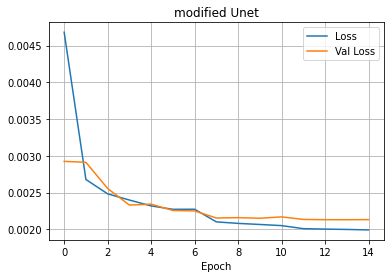

The best value of val_loss that in our case is the MSE on validation set is:  0.002129758009687066 Reached after  14  epochs.
The model was showing some really small signals of overfitting when the traing has been stopped


In [30]:
# Check overfit
loss_history = histu.history['loss']
val_loss_history = histu.history['val_loss']

plt.plot(loss_history)
plt.plot(val_loss_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'])
plt.title('modified Unet')
plt.show()

print('The best value of val_loss that in our case is the MSE on validation set is: ',min(histu.history['val_loss']),'Reached after ',
      (np.argmin(histu.history['val_loss'])+1), ' epochs.')
print('The model was showing some really small signals of overfitting when the traing has been stopped')

This model reaches a better performances and it does not overfit the learnig seems stable enough, and the loss on test, validation and also traing data are not so diffrent.

In [36]:
unet_model.save_weights('weigth_unetnigth1', save_format='h5')
# unet_model.save('Users\david\OneDrive\vecchio onedrive\Desktop\es', save_format='h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


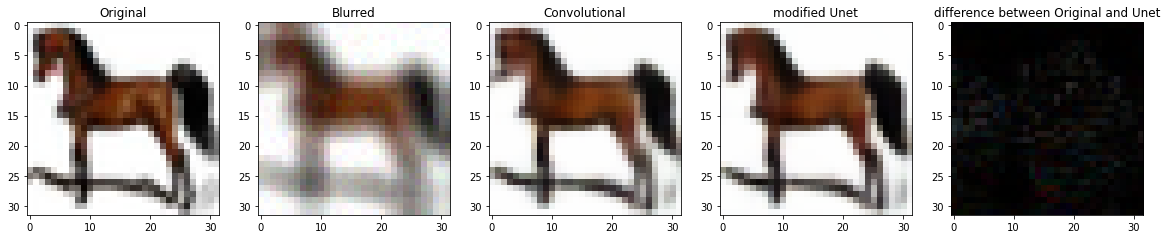

In [32]:
image_choiche = 2004  #21 , 1 , 2004
plt.figure(figsize=(20, 20))
plt.subplot(1,5,1)
plt.imshow(y_test[image_choiche]) #original
plt.title('Original')
plt.subplot(1,5,2)
plt.imshow(x_test[image_choiche]) # blurred
plt.title('Blurred')
plt.subplot(1,5,3)
plt.imshow(y_test_pred1[image_choiche]) # with conv2D
plt.title('Convolutional')
plt.subplot(1,5,4)
plt.imshow(y_test_pred_u[image_choiche]) # with Unet
plt.title('modified Unet')
plt.subplot(1,5,5)
plt.imshow(abs(y_test[1]-y_test_pred_u[1])) 
plt.title('difference between Original and Unet')

plt.show()

Text(0.5, 1.0, 'Convolutional')

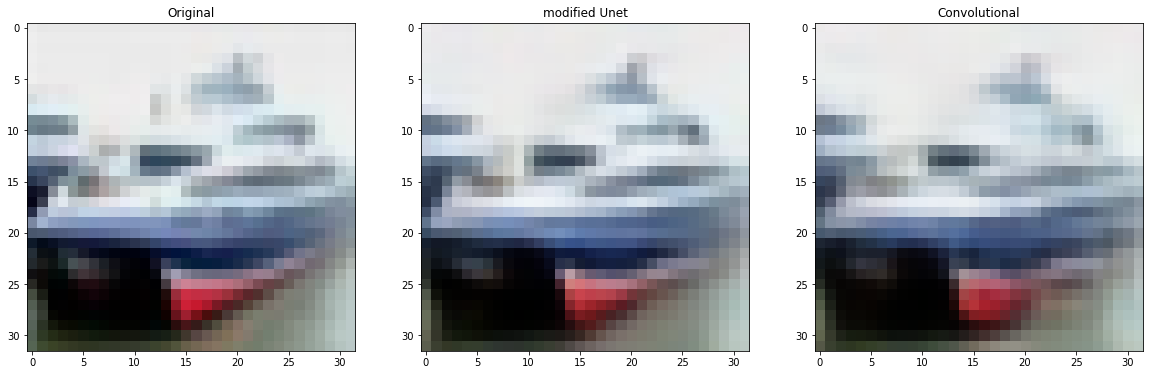

In [33]:
image_choiche = 1   #21 , 1 , 2004
plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(y_test[image_choiche]) #original
plt.title('Original')
plt.subplot(1,3,2)
plt.imshow(y_test_pred_u[image_choiche]) # blurred
plt.title('modified Unet')
plt.subplot(1,3,3)
plt.imshow(y_test_pred1[image_choiche]) # with conv2D
plt.title('Convolutional')

## Comments and conclusions

The **modified Unet** model has showed the best results in terms of **MSE** and it reaches thats result in few epochs, but after a visual inspection even the first fully convolutional model works well from an *human eye* perpsective. So deep learning models can be used for deblurring. 

<br> **Observations** <br>

*   The Gaussian blurring can remove noise but also some small details, but surprisingly the models are able to recover some of these features that had become almost invisible to the naked eye after the blurring. (see the immage below)
*   As said the Gaussian blurring can remove some small details, so it may be difficult to reduce al lot the MSE because some of these details may be very hard to recover without overfitting.


While this notebook was written, the dataset has been used for traning different models with different structure and number of paramters, but in almost all the cases there was no overfitting (or only small signals). <br> 
So this seem to a well structured dataset containig a lot of data that represent in a meaningfull the data on the test set. So it may be worth to try bigger networks. <br>
The data set is really big, but data augmentation may still improve performance, the Colab version that I use did not allow me to perform effective data augmentation without running out of RAM or forcing the interruption of the  training. <br>
It may be also worth to try to increase the batch size during the trainig.
Using the entire training set for training (having more training data) and test set as validation the Unet model reaches sligthly better results MSE on test 0.002137, is often not suggested to use the test set for validation, the risk is to overfit the parameters to reach good results on test set.



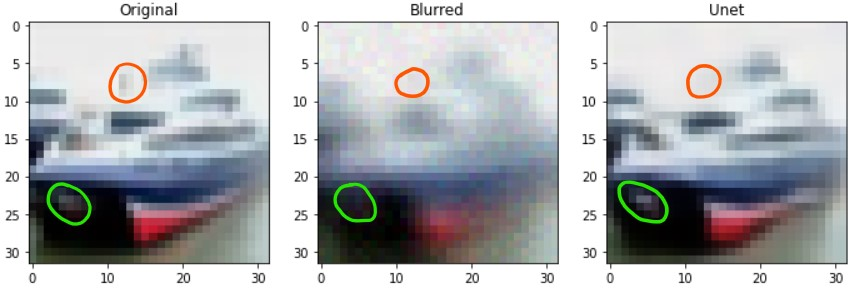

## References


1.   [Keras documentation](https://keras.io/search.html)
2.   [Tensorflow docunatation](https://www.tensorflow.org/api_docs/python/tf/keras)
3.  Slides and Labs of the course
4. [DON’T DECAY THE LEARNING RATE, INCREASE THE BATCH SIZE](https://arxiv.org/abs/1711.00489) <br>
Samuel L. Smith, Pieter-Jan Kindermans, Chris Ying & Quoc V. Le
Google Brain
 